# Tải thư viện cần thiết

In [ ]:
!pip install google-genai
! pip install git+https://github.com/huggingface/trl.git
! pip install transformers accelerate bitsandbytes peft datasets
! pip install tiktoken

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-zw0akp19
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-zw0akp19
  Resolved https://github.com/huggingface/trl.git to commit 3979cccad4574ddc51e3268645caa7efa943b291
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.26.0.dev0-py3-none-any.whl size=505722 sha256=1254426a86e8e38cc98b9ef9d1bc69a22bda51578d5726ab95036dde067d3124
  Stored in directory: /tmp/pip-ephem-wheel-cache-44wact04/wheels/0e/8f/95/dfd1c9271445f7e7e2fcfd9dfdcc8fabf9adc68edd4f2ea5fd
Successfully built trl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install -U trl==0.10.1 --no-cache-dir  # Phiên bản mới nhất 12/2025
!pip install -U transformers datasets accelerate peft bitsandbytes --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 255.2 MB/s eta 0:00:00
  Attempting uninstall: trl
    Found existing installation: trl 0.26.0.dev0
    Uninstalling trl-0.26.0.dev0:
      Successfully uninstalled trl-0.26.0.dev0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 208.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 249.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 246.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninsta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Khai báo thư viện

In [ ]:
import pandas as pd
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from google import genai
from google.colab import userdata
from google.genai import types
from google.genai.errors import APIError

from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    TrainingArguments, EarlyStoppingCallback
)
from trl import SFTTrainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset, Dataset

# Thiết lập đường dẫn

In [ ]:
import os
ROOT_MAPPINGS = {
    'hao-1': '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/',
    'hao-2': '/content/drive/MyDrive/TDTU/HK7/NLP/FinalTerm/',
    'hao-tdtu': '/content/drive/MyDrive/HK7/Natural_Language_Processing/FinalTerm/',
    'another-hao': '/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/',
}

ROOT = ROOT_MAPPINGS["another-hao"]
BASE_DIR = os.path.join(ROOT, 'Decoder_only')
DATASETS = os.path.join(BASE_DIR, 'Datasets')
MODELS = os.path.join(DATASETS, 'Models')

# tokenized_hf_data = os.path.join(DATASETS, 'tokenized_data')
classify_data = os.path.join(DATASETS, 'synthetic_final.csv')

# Sinh Data

In [ ]:
# Khởi tạo Gemini Client
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
client = genai.Client(api_key=GEMINI_API_KEY)

# Tiêu chí Độ dài (theo số từ)
MAX_ANSWER_WORDS = 50
MAX_QUESTION_WORDS = 25

OUTPUT_FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/synthetic_filtered_10000.csv"

SYSTEM_ROLE = (
    "Bạn là một chuyên gia huấn luyện mô hình ngôn ngữ lớn (LLM). "
    "Nhiệm vụ của bạn là tạo ra các cặp hỏi đáp (Question, Answer) mới "
    "trong kịch bản chăm sóc khách hàng/hỏi đáp về sản phẩm. "
    "Bạn phải tuân thủ định dạng JSON đầu ra được yêu cầu."
)

GENERATION_PROMPT_TEMPLATE = """
Dựa trên vai trò SYSTEM của bạn, hãy tạo ra 50 kịch bản hội thoại hoàn toàn mới liên quan đến các vấn đề: Giao hàng, Hoàn trả/Đổi trả, hoặc Bảo hành.

Mỗi kịch bản cần chọn một tên sản phẩm mới, ngẫu nhiên (chưa từng xuất hiện trong dữ liệu mẫu của tôi).

Mỗi kịch bản phải bao gồm một câu hỏi [USER] và một câu trả lời [ASSISTANT] chuyên nghiệp, hữu ích, tuân thủ vai trò chăm sóc khách hàng.

5. Quy tắc độ dài: Câu hỏi [USER] không được quá 25 từ. Câu trả lời [ASSISTANT] phải ngắn gọn, chỉ nêu thông tin cần thiết và không được quá 50 từ.

Đảm bảo đầu ra là một JSON Array hợp lệ (KHÔNG CÓ bất kỳ văn bản giải thích nào khác ngoài JSON):
[
  {{
    "product_name": "Tên sản phẩm mới",
    "question": "Câu hỏi [USER] mới",
    "answer": "Câu trả lời [ASSISTANT] mới"
  }},
  ...
]
"""

# HÀM LỌC BỔ SUNG
def apply_filtering(df_synthetic):
    """
    Áp dụng tiêu chí lọc Độ dài cho dữ liệu Synthetic.

    Args:
        df_synthetic (pd.DataFrame): Dữ liệu synthetic vừa sinh ra.

    Returns:
        pd.DataFrame: Dữ liệu synthetic đã được lọc.
    """
    print(f"Bắt đầu lọc: {len(df_synthetic)} mẫu")
    df_filtered = df_synthetic.copy()

    # Lọc theo Độ dài
    # Tính độ dài câu hỏi và câu trả lời theo số từ
    df_filtered['question_len'] = df_filtered['question'].apply(lambda x: len(str(x).split()))
    df_filtered['answer_len'] = df_filtered['answer'].apply(lambda x: len(str(x).split()))

    initial_count = len(df_filtered)

    # Áp dụng giới hạn độ dài
    df_filtered = df_filtered[
        (df_filtered['question_len'] <= MAX_QUESTION_WORDS) &
        (df_filtered['answer_len'] <= MAX_ANSWER_WORDS)
    ]

    # Loại bỏ các cột phụ trợ
    df_filtered_final = df_filtered.drop(columns=['question_len', 'answer_len'])

    return df_filtered_final


# Hàm sinh data
def generate_synthetic_data(num_batches, model_name="gemini-2.5-flash"):
    """
    Hàm gọi API để sinh dữ liệu synthetic theo lô (batch).
    """
    global client

    all_synthetic_data = []

    for i in range(num_batches):

        try:
            response = client.models.generate_content(
                model=model_name,
                contents=[SYSTEM_ROLE, GENERATION_PROMPT_TEMPLATE],
                config=types.GenerateContentConfig(
                    response_mime_type="application/json",
                ),
            )

            response_text = response.text
            data_batch = json.loads(response_text)
            all_synthetic_data.extend(data_batch)

            # XỬ LÝ VÀ LỌC LÔ ĐÓ (Thay vì gộp vào list lớn)
            df_batch = pd.DataFrame(data_batch)

            # Bắt đầu lọc (dùng hàm đã sửa đổi trước đó)
            df_batch_filtered = apply_filtering(df_batch)

            # LƯU LÔ ĐÃ LỌC VÀO FILE
            df_batch_filtered.to_csv(OUTPUT_FILE_PATH, index=False, mode='a', header=False)
            print(f"Lô {i+1} đã được lưu: {len(df_batch_filtered)} mẫu.")

        except json.JSONDecodeError:
            print(f"Lô {i+1}: Lỗi JSON. Văn bản: {response_text[:50]}...")
            continue
        except APIError as e: # BẮT LỖI API CỤ THỂ
            error_message = str(e)
            if '503 UNAVAILABLE' in error_message or 'Rate Limit' in error_message:
                # Tăng thời gian chờ nếu gặp lỗi quá tải
                delay_time = 30
                print(f"Lô {i+1}: Gặp lỗi 503/Quá tải. Đang chờ {delay_time} giây và thử lại lô này...")
                time.sleep(delay_time)

                # Thử lại lô hiện tại
                i -= 1 # Giảm i để vòng lặp chạy lại lô hiện tại
                continue
        except Exception as e:
            print(f"Lô {i+1}: Lỗi không xác định: {e}")
            continue

    print(f"\nQUÁ TRÌNH HOÀN TẤT. Dữ liệu đã được lưu vào: {OUTPUT_FILE_PATH}")
    return None

# Chạy quá trình sinh dữ liệu và lưu trực tiếp
df_final_synthetic = generate_synthetic_data(num_batches=100)
print("Hoàn tất quá trình sinh và lọc dữ liệu synthetic!")

# Gộp 2  file data

In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/"

# Danh sách tên các file synthetic data
file_names = [
    "synthetic_repaired_10000.csv",
    "synthetic_raw_5000.csv"
]

# Tạo danh sách đường dẫn đầy đủ
file_paths = [os.path.join(FOLDER_PATH, f) for f in file_names]

In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/"
FAULTY_FILE_PATH = os.path.join(FOLDER_PATH, "synthetic_filtered_10000.csv")

# Đọc file bị lỗi (giả định nó không có header hoặc header bị lỗi)
# Tên cột tạm thời: C0, C1, C2
df_faulty = pd.read_csv(FAULTY_FILE_PATH, header=None)

# Gán lại Tên Cột Chính xác
df_faulty.columns = ['product_name', 'question', 'answer']

#Lưu lại file đã sửa với header chính xác
df_faulty.to_csv(os.path.join(FOLDER_PATH, "synthetic_repaired_10000.csv"), index=False)
print(f"Đã sửa và lưu file 10000 mẫu vào synthetic_repaired_10000.csv")

In [ ]:
from pandas import concat

# tạo danh sách các DataFrame
list_of_dfs = []

for path in file_paths:
    print(f"Đang đọc file: {path}...")
    try:
        df = pd.read_csv(path)
        list_of_dfs.append(df)
        print(f"-> Đã đọc {len(df)} mẫu.")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {path}")

# Gộp tất cả các DataFrame lại thành một
# ignore_index=True đảm bảo index của DataFrame cuối cùng là liên tục (0, 1, 2, ...)
df_combined_synthetic = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- KẾT QUẢ GỘP ---")
print(f"Tổng số mẫu synthetic data: {len(df_combined_synthetic)} mẫu.")
print(df_combined_synthetic.head())

OUTPUT_COMBINED_PATH = os.path.join(FOLDER_PATH, "synthetic_final_raw.csv")
df_combined_synthetic.to_csv(OUTPUT_COMBINED_PATH, index=False)
print(f"\nĐã lưu tập dữ liệu cuối cùng tại: {OUTPUT_COMBINED_PATH}")

# Gộp synthetic data + data gốc

In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/"

# Danh sách tên các file synthetic data
file_names = [
    "synthetic_final_raw.csv",
    "Dataset03.csv"
]

# Tạo danh sách đường dẫn đầy đủ
file_paths = [os.path.join(FOLDER_PATH, f) for f in file_names]

In [ ]:
from pandas import concat

# tạo danh sách các DataFrame
list_of_dfs = []

for path in file_paths:
    print(f"Đang đọc file: {path}...")
    try:
        df = pd.read_csv(path)
        list_of_dfs.append(df)
        print(f"-> Đã đọc {len(df)} mẫu.")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {path}")

# Gộp tất cả các DataFrame lại thành một
# ignore_index=True đảm bảo index của DataFrame cuối cùng là liên tục (0, 1, 2, ...)
df_combined = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- KẾT QUẢ GỘP ---")
print(f"Tổng số mẫu synthetic data: {len(df_combined)} mẫu.")
print(df_combined.head())

OUTPUT_COMBINED_PATH = os.path.join(FOLDER_PATH, "synthetic_final.csv")
df_combined.to_csv(OUTPUT_COMBINED_PATH, index=False)
print(f"\nĐã lưu tập dữ liệu cuối cùng tại: {OUTPUT_COMBINED_PATH}")

Đang đọc file: /content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/synthetic_final_raw.csv...
-> Đã đọc 14416 mẫu.
Đang đọc file: /content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/Dataset03.csv...
-> Đã đọc 46520 mẫu.

--- KẾT QUẢ GỘP ---
Tổng số mẫu synthetic data: 60936 mẫu.
                   product_name  \
0          Đèn Thông Minh Lumos   
1            Bàn Phím Cơ Zenith   
2    Đồng Hồ Thông Minh Chronos   
3    Máy Lọc Không Khí AeroPure   
4  Tai Nghe Không Dây AuraSound   

                                            question  \
0  Tôi đã đặt Đèn Thông Minh Lumos từ 3 ngày trướ...   
1  Tôi muốn đổi Bàn Phím Cơ Zenith sang màu khác....   
2  Đồng Hồ Thông Minh Chronos của tôi gặp lỗi pin...   
3  Tôi có thể thay đổi địa chỉ giao hàng cho Máy ...   
4  Tôi không hài lòng với Tai Nghe Không Dây Aura...   

                                              answer  
0  Đơn hàng của bạn dự kiến giao trong 5-7 ngày l...  
1  Bạn có thể đổi sản phẩm trong 7 ngày nếu còn 

In [ ]:
# Kiểm tra dữ liệu trùng lặp
def check_and_count_duplicates(file_path):
    """
    Kiểm tra và in ra các mẫu dữ liệu bị trùng lặp và số lần trùng lặp.

    Args:
        file_path (str): Đường dẫn đến file CSV chứa dữ liệu.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Đã đọc thành công {len(df)} mẫu dữ liệu từ file.")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {file_path}")
        return

    # Xác định các hàng bị trùng lặp
    # subset: Chỉ định các cột được dùng để xác định tính trùng lặp.
    # keep=False: Đánh dấu TẤT CẢ các bản sao (bao gồm cả bản gốc) là True.
    duplicated_rows = df[
        df.duplicated(
            subset=['product_name', 'question', 'answer'],
            keep=False
        )
    ]

    if duplicated_rows.empty:
        print("\n=> Không tìm thấy mẫu dữ liệu nào bị trùng lặp căn bản (Exact Duplicates).")
        return

    # Đếm số lần xuất hiện của mỗi mẫu trùng lặp
    # Tạo một Series mới bằng cách gộp các cột trùng lặp
    duplicate_counts = duplicated_rows.groupby(
        ['product_name', 'question', 'answer']
    ).size().reset_index(name='Trùng Lặp (Lần)')

    # Lọc chỉ những mẫu trùng lặp thực sự (xuất hiện > 1 lần)
    duplicate_counts = duplicate_counts[duplicate_counts['Trùng Lặp (Lần)'] > 1]

    # Sắp xếp theo số lần trùng lặp giảm dần
    duplicate_counts = duplicate_counts.sort_values(
        by='Trùng Lặp (Lần)',
        ascending=False
    )

    print(f"\n=> TÌM THẤY {len(duplicate_counts)} MẪU ĐỘC NHẤT BỊ TRÙNG LẶP:")

    # In kết quả
    # Hiển thị số lượng và thông tin chi tiết của các mẫu trùng lặp
    print(duplicate_counts.to_markdown(index=False, numalign="left", stralign="left"))

# THAY ĐỔI ĐƯỜNG DẪN NÀY CHO PHÙ HỢP VỚI FILE CUỐI CÙNG CỦA BẠN
FILE_PATH = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/Datasets/synthetic_final.csv"

check_and_count_duplicates(FILE_PATH)

Đã đọc thành công 60936 mẫu dữ liệu từ file.

=> TÌM THẤY 22 MẪU ĐỘC NHẤT BỊ TRÙNG LẶP:
| product_name                                                      | question                                                                                                                                                    | answer                                                                                                                                                      | Trùng Lặp (Lần)   |
|:------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------|
| Dép Nữ - Dép Cao Gót Nữ Da Bò BIGBEN DCG28                        | Tôi muốn mua đôi Dép Cao Gót N

# Khởi tạo mô hình

In [ ]:
model_id = "Qwen/Qwen3-0.6B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="sdpa",
    dtype=torch.float16,
    low_cpu_mem_usage=True,
)

model.gradient_checkpointing_enable()
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'right'

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    model.resize_token_embeddings(len(tokenizer))

print(tokenizer.pad_token)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

<|endoftext|>


In [ ]:
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Qwen3 dùng các module này
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=None,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 598,343,680 || trainable%: 0.3834


# Dữ liệu

## Định dạng format chatbot

In [ ]:
df = pd.read_csv(classify_data)
df = df.dropna(subset=['product_name', 'question', 'answer'])

# Xây dựng hàm định dạng chuỗi
def format_conversation(row):
    messages = [
        {"role": "system", "content": f"Sản phẩm: {row['product_name'].strip()}"},
        {"role": "user",   "content": row['question'].strip()},
        {"role": "assistant", "content": row['answer'].strip()}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False   # không thêm "assistant\n" ở cuối khi train
    )
    return text

df["text"] = df.apply(format_conversation, axis=1)

# Tạo Dataset, nhưng GIỮ LẠI các cột gốc
dataset = Dataset.from_pandas(df)


# ---- Chia thành 80% train, 20% tạm thời ----
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

# ---- Chia tiếp 20% thành validation + test (10% - 10%) ----
valid_test = dataset_split["test"].train_test_split(test_size=0.5, seed=42)

# ---- Gom lại thành bộ 3 ----
dataset_final = {
    "train": dataset_split["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
}

print(
    f"Train: {len(dataset_final['train'])} mẫu | "
    f"Validation: {len(dataset_final['validation'])} mẫu | "
    f"Test: {len(dataset_final['test'])} mẫu"
)

Train: 48736 mẫu | Validation: 6092 mẫu | Test: 6092 mẫu


In [ ]:
print(dataset_final["train"][106]["text"])

<|im_start|>system
Sản phẩm: Áo thun nam ngắn tay cổ tròn cao cấp Big Sport<|im_end|>
<|im_start|>user
Cảm ơn bạn đã giải đáp thắc mắc của tôi. Tôi sẽ cân nhắc và sớm đặt hàng.<|im_end|>
<|im_start|>assistant
<think>

</think>

Chúng tôi rất hân hạnh được phục vụ bạn. Nếu bạn có bất kỳ câu hỏi nào khác, xin vui lòng liên hệ với chúng tôi.<|im_end|>



## Trực quan dữ liệu

### Phân bố số lượng mẫu của các tập dữ liệu

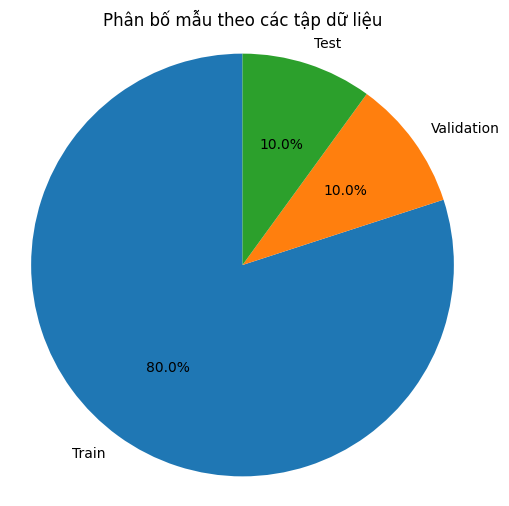

In [ ]:
# Lấy số lượng mẫu
sizes = [
    len(dataset_final["train"]),
    len(dataset_final["validation"]),
    len(dataset_final["test"])
]

labels = ["Train", "Validation", "Test"]

# Vẽ biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Phân bố mẫu theo các tập dữ liệu")
plt.axis("equal")  # đảm bảo hình tròn cân đối
plt.show()


### Max len của các dataset

In [ ]:
def compute_token_lengths(dataset, tokenizer, text_field="text"):
    lengths = []
    for x in dataset[text_field]:
        ids = tokenizer(x, add_special_tokens=True)['input_ids']
        lengths.append(len(ids))
    return np.array(lengths)

def compute_range_stats(lengths, thresholds=[128, 256, 384, 512, 768]):
    lengths = np.array(lengths)
    total = len(lengths)

    ranges = []
    prev = 0
    for t in thresholds:
        count = ((lengths >= prev) & (lengths <= t)).sum()
        pct = count / total * 100
        ranges.append((f"{prev}–{t}", pct))
        prev = t + 1

    # Khoảng cuối
    count = (lengths >= prev).sum()
    pct = count / total * 100
    ranges.append((f">= {prev}", pct))

    return ranges

def build_distribution_table(train_ranges, val_ranges, test_ranges):
    df = pd.DataFrame({
        "Range": [r[0] for r in train_ranges],
        "Train (%)": [round(r[1], 2) for r in train_ranges],
        "Validation (%)": [round(r[1], 2) for r in val_ranges],
        "Test (%)": [round(r[1], 2) for r in test_ranges],
    })
    return df

In [ ]:
def plot_max_len_ratio(train_dist, val_dist, test_dist):
    ranges = [x[0] for x in train_dist]
    train_vals = [x[1] for x in train_dist]
    val_vals   = [x[1] for x in val_dist]
    test_vals  = [x[1] for x in test_dist]

    x = np.arange(len(ranges))
    width = 0.25

    plt.figure(figsize=(12, 6))

    plt.bar(x - width, train_vals, width, label="Train")
    plt.bar(x, val_vals, width, label="Validation")
    plt.bar(x + width, test_vals, width, label="Test")

    plt.xticks(x, ranges, rotation=45)
    plt.ylabel("Tỉ lệ mẫu (%)")
    plt.title("So sánh phân bố độ dài token theo các khoảng")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_avg_comparison(train_avg, val_avg, test_avg):
    names = ["Train", "Validation", "Test"]
    values = [train_avg, val_avg, test_avg]

    plt.figure(figsize=(8, 6))
    plt.bar(names, values)
    plt.ylabel("Average Token Length")
    plt.title("So sánh độ dài token trung bình giữa các tập")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# 1) Tính token length cho 3 tập
train_lengths = compute_token_lengths(dataset_final["train"], tokenizer)
val_lengths   = compute_token_lengths(dataset_final["validation"], tokenizer)
test_lengths  = compute_token_lengths(dataset_final["test"], tokenizer)

# 2) Phân loại theo khoảng
thresholds = [128, 256, 384, 512]

train_ranges = compute_range_stats(train_lengths, thresholds)
val_ranges   = compute_range_stats(val_lengths, thresholds)
test_ranges  = compute_range_stats(test_lengths, thresholds)

distribution = build_distribution_table(train_ranges, val_ranges, test_ranges)
display(distribution)

,Range,Train (%),Validation (%),Test (%)
0,0–128,91.50,91.27,91.25
1,129–256,8.47,8.70,8.75
2,257–384,0.02,0.03,0.00
3,385–512,0.00,0.00,0.00
4,>= 513,0.00,0.00,0.00


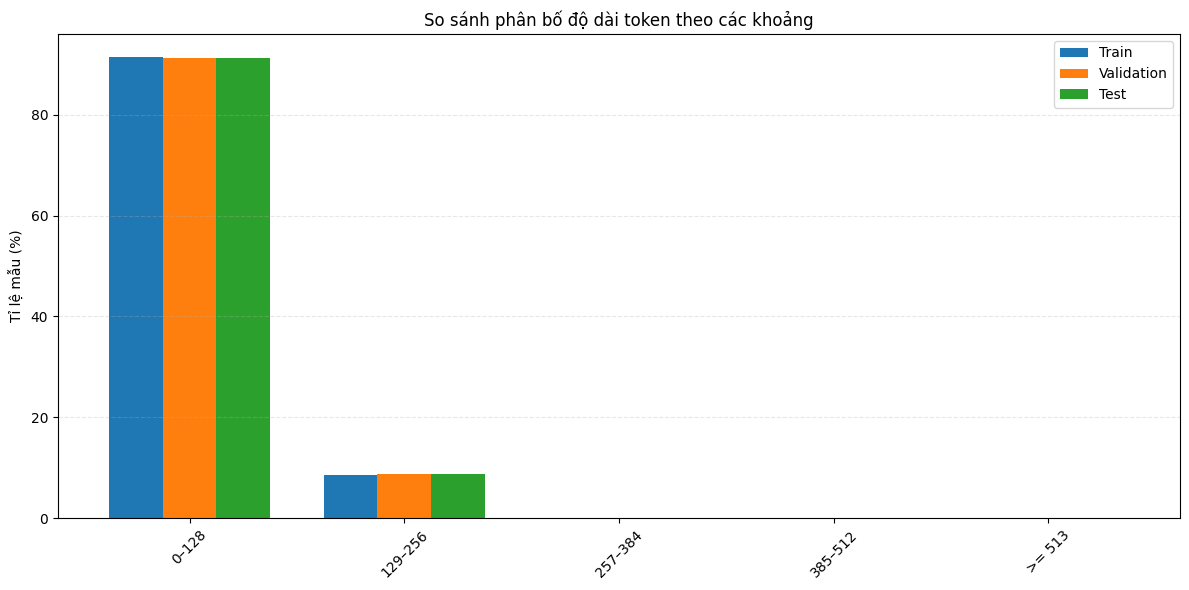

In [ ]:
plot_max_len_ratio(train_ranges, val_ranges, test_ranges)

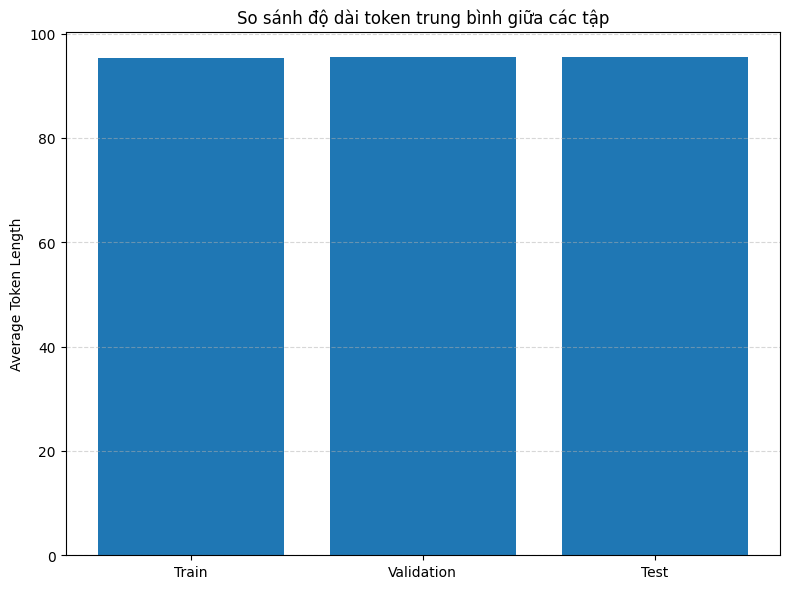

In [ ]:
train_avg = np.mean(train_lengths)
val_avg   = np.mean(val_lengths)
test_avg  = np.mean(test_lengths)

plot_avg_comparison(train_avg, val_avg, test_avg)

## Tokenize dataset

In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding=False,
    )
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

tokenized_dataset = {
    "train": dataset_final["train"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["train"].column_names if c != "text"],
    ),
    "validation": dataset_final["validation"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["validation"].column_names if c != "text"],
    ),
    "test": dataset_final["test"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["test"].column_names if c != "text"],
    ),
}

Map:   0%|          | 0/48736 [00:00<?, ? examples/s]

Map:   0%|          | 0/6092 [00:00<?, ? examples/s]

Map:   0%|          | 0/6092 [00:00<?, ? examples/s]

In [ ]:
# Data collator tự động pad khi train
from trl import DataCollatorForCompletionOnlyLM

data_collator = DataCollatorForCompletionOnlyLM(
    response_template="<|im_start|>assistant\n",
    tokenizer=tokenizer,
    mlm=False,
)

In [ ]:
# output_dir = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/qwen3-customer-support-finetuned"
# final_dir = "/content/drive/MyDrive/NLP/FinalTerm/Decoder_only/qwen3-customer-support-final"
output_dir = os.path.join(BASE_DIR, "qwen3-finetuned")
final_dir = os.path.join(BASE_DIR, "qwen3-final")

print(output_dir)
print(final_dir)

/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-finetuned
/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-final


# Cấu hình mô hình

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",

    # Tham số Huấn luyện chính
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    optim="adamw_torch_fused",
    learning_rate=3e-4,
    lr_scheduler_type="cosine",

    warmup_ratio=0.03,
    weight_decay=0.01,  # tránh overfitting
    max_grad_norm=1.0,

    # Logging và Đánh giá
    logging_steps=10,
    save_strategy="epoch", # Lưu checkpoint sau mỗi epoch vào Drive
    eval_strategy="epoch",
    load_best_model_at_end=True,
    gradient_checkpointing=True,

    # Kỹ thuật Tăng tốc
    group_by_length=False,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    fp16=True,
    metric_for_best_model="eval_loss",
    seed=42,
    data_seed=42
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_final["train"],
    eval_dataset=dataset_final["validation"],
    tokenizer=tokenizer,
    dataset_text_field="text",      # SFTTrainer tự tokenize
    max_seq_length=256,            # tự truncate
    packing=False,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/48736 [00:00<?, ? examples/s]

Map:   0%|          | 0/6092 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:412: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The model is already on multiple devices. Skipping the move to device specified in `args`.


# Load checkpoint để train tiếp (nếu có)

In [ ]:
def get_latest_checkpoint(output_dir):
    if not os.path.exists(output_dir):
        return None

    checkpoints = [
        os.path.join(output_dir, d) for d in os.listdir(output_dir)
        if d.startswith("checkpoint-")
    ]

    if not checkpoints:
        return None

    # Sort theo số checkpoint
    checkpoints = sorted(
        checkpoints,
        key=lambda x: int(x.split("-")[-1].split(" ")[0])
    )

    return checkpoints[-1]   # trả checkpoint mới nhất


latest_checkpoint = get_latest_checkpoint(output_dir)
if latest_checkpoint:
    print(f" Đang tiếp tục train từ checkpoint: {latest_checkpoint}")
else:
    print("Không tìm thấy checkpoint — bắt đầu train từ đầu")

 Đang tiếp tục train từ checkpoint: /content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-finetuned/checkpoint-3046


# Training

In [ ]:
trainer.train(
    resume_from_checkpoint=latest_checkpoint
)

# Lưu model đã fine-tune
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"Model đã lưu vào thư mục {final_dir}")

Epoch,Training Loss,Validation Loss
1,0.718700,0.639881
2,0.567500,0.578560


KeyboardInterrupt: 

In [ ]:
# train tiếp ở another-hao
trainer.train(
    resume_from_checkpoint=latest_checkpoint
)

# Lưu model đã fine-tune
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print("Model đã lưu vào thư mục qwen3-final")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Epoch,Training Loss,Validation Loss
3,0.569500,0.570681
4,0.469500,0.556372
5,0.451000,0.553296
6,0.428400,0.557166


Model đã lưu vào thư mục qwen3-final


In [ ]:
print(trainer)

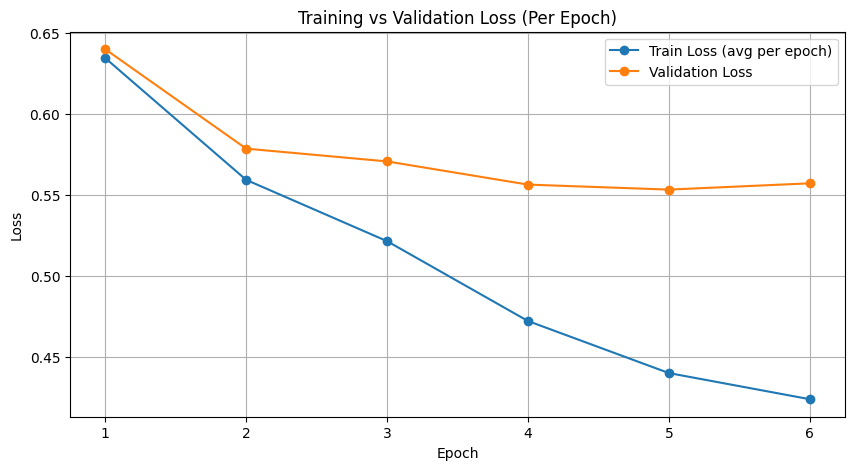

In [ ]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

def load_epoch_losses(output_dir):

    logs = []

    # Tìm tất cả trainer_state.json
    json_paths = glob.glob(f"{output_dir}/**/trainer_state.json", recursive=True)

    for path in json_paths:
        with open(path, "r") as f:
            state = json.load(f)
            if "log_history" in state:
                logs.extend(state["log_history"])

    df = pd.DataFrame(logs)

    # Chỉ giữ record có epoch (step logs không có)
    df = df[df["epoch"].notna()]

    # # ----- Train Loss -----
    train_df = df[df["loss"].notna()]
    train_epoch_loss = train_df.groupby(train_df["epoch"].round())["loss"].mean()
    train_epoch_loss = train_epoch_loss[train_epoch_loss.index > 0]

    # # ----- Validation Loss -----
    val_df = df[df["eval_loss"].notna()]
    val_epoch_loss = val_df.groupby(val_df["epoch"].round())["eval_loss"].mean()


    return train_epoch_loss, val_epoch_loss


def plot_epoch_loss(train_epoch_loss, val_epoch_loss):

    plt.figure(figsize=(10, 5))

    plt.plot(train_epoch_loss.index, train_epoch_loss.values,
             marker="o", label="Train Loss (avg per epoch)")

    plt.plot(val_epoch_loss.index, val_epoch_loss.values,
             marker="o", label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (Per Epoch)")
    plt.grid(True)
    plt.legend()
    plt.xticks(train_epoch_loss.index)  # Hiển thị các epoch integer

    plt.show()

train_loss, val_loss = load_epoch_losses(output_dir)
plot_epoch_loss(train_loss, val_loss)

# Đánh giá trên tập test

In [ ]:
print(final_dir)
model = AutoModelForCausalLM.from_pretrained(
    final_dir,
    device_map="auto",
    dtype=torch.float16,
    trust_remote_code=True,
    attn_implementation="sdpa",
)

tokenizer = AutoTokenizer.from_pretrained(final_dir)
tokenizer.padding_side = "right"

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    model.resize_token_embeddings(len(tokenizer))

print(tokenizer.pad_token)

/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-final
<|endoftext|>


In [ ]:
import math

def evaluate_loss_ppl(trainer, dataset):
    print("=== Evaluate Loss + Perplexity ===")

    results = trainer.evaluate()

    test_loss = results["eval_loss"]
    ppl = math.exp(test_loss)

    print(f"Test Loss = {test_loss:.4f}")
    print(f"Test Perplexity = {ppl:.4f}")

    return test_loss, ppl

test_loss, test_ppl = evaluate_loss_ppl(trainer, tokenized_dataset["test"])

=== Evaluate Loss + Perplexity ===


Test Loss = 0.6127
Test Perplexity = 1.8454


# Trực quan 1 vài mẫu test

In [ ]:
import random
import torch

def show_test_samples(model, tokenizer, dataset, num_samples=5, max_new_tokens=200):
    model.eval()
    samples = random.sample(list(dataset), num_samples)

    for i, row in enumerate(samples, 1):
        print("\n" + "=" * 100)
        print(f"🟦 SAMPLE {i}")

        # ===========================
        # 1) Build inference prompt — KHÔNG có ground truth
        # ===========================
        prompt = tokenizer.apply_chat_template(
            [
                {"role": "system", "content": f"Sản phẩm: {row['product_name']}"},
                {"role": "user", "content": row['question']},
            ],
            tokenize=False,
            add_generation_prompt=True  # rất quan trọng
        )

        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # ===========================
        # 2) Model generate
        # ===========================
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                eos_token_id=tokenizer.eos_token_id,
            )

        decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # ===========================
        # 3) Tách phần model sinh ra khỏi prompt
        # ===========================
        model_answer = decoded.replace(prompt, "").strip()

        # ===========================
        # 4) Print everything
        # ===========================
        print("🔶 PROMPT:")
        print(prompt)

        print("\n🟩 QUESTION:")
        print(row["question"])

        print("\n🟥 GROUND TRUTH:")
        print(row["answer"])

        print("\n🟦 MODEL OUTPUT:")
        print(model_answer)

        print("=" * 100)


# Gọi hàm
show_test_samples(
    model=model,
    tokenizer=tokenizer,
    dataset=dataset_final["test"],
    num_samples=5,
    max_new_tokens=200
)


🟦 SAMPLE 1
🔶 PROMPT:
<|im_start|>system
Sản phẩm: Giày Đá Banh kèm 1 Đôi Vớ Dài Tới Gối Cao Cấp<|im_end|>
<|im_start|>user
Tôi muốn so sánh Giày Đá Banh kèm 1 Đôi Vớ Dài Tới Gối Cao Cấp với những sản phẩm cùng loại khác.<|im_end|>
<|im_start|>assistant


🟩 QUESTION:
Tôi muốn so sánh Giày Đá Banh kèm 1 Đôi Vớ Dài Tới Gối Cao Cấp với những sản phẩm cùng loại khác.

🟥 GROUND TRUTH:
Được rồi! Bạn có thể truy cập danh mục Giày Đá Banh trên trang web của chúng tôi để xem các sản phẩm tương tự và so sánh chúng với sản phẩm bạn đã chọn.

🟦 MODEL OUTPUT:
system
Sản phẩm: Giày Đá Banh kèm 1 Đôi Vớ Dài Tới Gối Cao Cấp
user
Tôi muốn so sánh Giày Đá Banh kèm 1 Đôi Vớ Dài Tới Gối Cao Cấp với những sản phẩm cùng loại khác.
assistant
<think>

</think>

Tôi không thể so sánh sản phẩm này với các sản phẩm khác, vì tôi không có thông tin về các sản phẩm cùng loại khác.

🟦 SAMPLE 2
🔶 PROMPT:
<|im_start|>system
Sản phẩm: bộ đùi vải đũi size đại<|im_end|>
<|im_start|>user
Thế thì tôi không mua nữa, tôi sẽ 

# Inference với Input

In [ ]:
def chat_with_model(product_name, question, model=model, tokenizer=tokenizer,
                    max_new_tokens=200, temperature=0.7, top_p=0.9):
    """
    Hàm dùng model đã fine-tune để trả lời câu hỏi về sản phẩm.
    Truyền vào tên sản phẩm và câu hỏi.
    """

    model.eval()

    # Build chat prompt theo đúng template Qwen 3
    prompt = tokenizer.apply_chat_template(
        [
            {"role": "system", "content": f"Sản phẩm: {product_name}"},
            {"role": "user", "content": question},
        ],
        tokenize=False,
        add_generation_prompt=True
    )

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode full sequence
    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Tách phần model sinh ra khỏi prompt
    answer = decoded.replace(prompt, "").strip()

    return answer

In [ ]:
product = "Áo thun nam ngắn tay cổ tròn cao cấp Big Sport"
question = "Cảm ơn bạn đã giải đáp thắc mắc của tôi. Tôi sẽ cân nhắc và sớm đặt hàng."

generated_answer = chat_with_model(product, question)
print("Model trả lời:", generated_answer)


Model trả lời: system
Sản phẩm: Áo thun nam ngắn tay cổ tròn cao cấp Big Sport
user
Cảm ơn bạn đã giải đáp thắc mắc của tôi. Tôi sẽ cân nhắc và sớm đặt hàng.
assistant
<think>

</think>

Tôi rất vui khi được hỗ trợ bạn. Nếu bạn có bất kỳ câu hỏi nào khác, đừng ngần ngại liên hệ với chúng tôi.


# Tạo mẫu để đánh giá bằng LLM

In [ ]:
from tqdm import tqdm

# ---- 1. Lấy 10 mẫu ngẫu nhiên từ test ----
test_df = dataset_final["test"].to_pandas()
sample_df = test_df.sample(n=10, random_state=42).reset_index(drop=True)

# ---- 2. Hàm sinh câu trả lời ----
def generate_answer(product_name, question, model, tokenizer, max_new_tokens=120):
    messages = [
        {"role": "system", "content": f"Sản phẩm: {product_name}"},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Cắt phần prompt để giữ phần model trả lời
    if "assistant" in decoded:
        decoded = decoded.split("assistant", 1)[-1].strip()

    return decoded

# ---- 3. Model sinh output cho 10 mẫu ----
results = []

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    model_output = generate_answer(
        row["product_name"],
        row["question"],
        model,
        tokenizer
    )

    results.append({
        "product_name": row["product_name"],
        "user_question": row["question"],
        "ground_truth": row["answer"],
        "model_output": model_output
    })

# ---- 4. Xuất CSV ----
output_file = os.path.join(BASE_DIR, "llm_eval_samples.csv")
pd.DataFrame(results).to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"Đã xuất file: {output_file}")


100%|██████████| 10/10 [00:55<00:00,  5.60s/it]

Đã xuất file: /content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/llm_eval_samples.csv
